## Get states for each work trajectory for A42T apo

In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random
from simtk.openmm.app import Modeller


In [2]:
# Get dihedrals
def get_dihedrals(i, phase, direction, outdir, htf, dihedral_indices_new, dihedral_indices_old):
    # Get topology with solute only
    modeller = Modeller(htf._topology_proposal.new_topology, htf.new_positions(htf.hybrid_positions))
    modeller.deleteWater()
    new_top = md.Topology.from_openmm(modeller.topology)
    
    # Get last positions from eq positions of each cycle (positions are solute only)
    from tqdm import tqdm
    all_pos_new = []
    for j in tqdm(range(100)):
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_{direction}_eq_new.npy"), "rb") as f:
                all_pos_new.append(np.load(f)[-1])
        except FileNotFoundError:
            pass
    print(f"new files found: {len(all_pos_new)}")
    
    # Compute dihedrals
    traj = md.Trajectory(np.array(all_pos_new), new_top)
    dihedrals_new = md.compute_dihedrals(traj, np.array([dihedral_indices_new]))
    
    return dihedrals_new

#### Get dihedrals for apo

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/32/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [4]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [5]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 681]
dihedrals_new_apo = get_dihedrals(i, phase, 'reverse', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:02<00:00, 35.65it/s]

new files found: 100


#### Get dihedrals for complex

In [6]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/32/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir))


In [7]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [8]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 681]
dihedrals_new_complex = get_dihedrals(i, phase, 'reverse', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:04<00:00, 24.58it/s]

new files found: 86


In [9]:
# Define indicator function
def get_state(dihedral_angle):
    if dihedral_angle > 2 or dihedral_angle < -2: # angle is -3 or +3
        return 0
    elif dihedral_angle < 0 and dihedral_angle > -2: # angle is -1
        return 1
    elif dihedral_angle > 0 and dihedral_angle < 2: # angle is 1
        return 2

In [10]:
# Create list of states for each work traj
states_apo = [get_state(angle) for angle in dihedrals_new_apo]
states_complex = [get_state(angle) for angle in dihedrals_new_complex]

In [11]:
for angle in dihedrals_new_complex:
    if get_state(angle) == 1:
        print(angle, get_state(angle)) 

[-1.0685793] 1
[-1.0845848] 1
[-0.9312245] 1
[-0.8554928] 1
[-0.8068254] 1
[-0.5733231] 1
[-1.006817] 1
[-0.6767622] 1
[-0.7928603] 1
[-1.0732489] 1
[-1.0355427] 1
[-0.87092644] 1
[-1.1196643] 1
[-0.6719296] 1
[-1.0486785] 1
[-0.6534049] 1


## Run estimator

In [12]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [13]:
def analyze_minh(input_works):
    """
    symmetric protocol free energy that gavin got from plugging in symmetric protocols into bidirectional estimator
    
    arguments
        input_works : np.array(N, 2)
            input_works[:,0] is work  accumulated from start to midpoint
            input_works[:,1] is work accumulated from midpoint to end
    
    returns
        free_energy : float
            reduced free energy
    """
    N = input_works.shape[0]
    w_abs, w_bcs = input_works[:,0], input_works[:,1]
    w_ab_max, w_bc_max = np.max(w_abs), np.max(w_bcs)
    
    denominators = np.exp(w_abs - w_ab_max) + np.exp(-w_bcs - w_ab_max)
    
    return -np.log(2./N) - np.log(np.sum(1./denominators)) + w_ab_max

In [14]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [15]:
# Prep work arrays (from distributed jobs) and call analyze()
# titles = ["T42A", "A42T", "Y29A", "A29Y", "W38F", "F38W", "W44F", "F44W", "Y29F", "F29Y"]
titles = ["A42T"]
d_results = {}
d_phases = {}
first = 32
for i in tqdm_notebook([32]):
    print(f"dir: {i}")
    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []
    for j in range(100):
        print(f"job: {j}")
        forward_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/8/{i}/{i}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/8/{i}/{i}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/8/{i}/{i}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/8/{i}/{i}_apo_{j}_reverse.npy'
        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                array = np.load(f)
                forward_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                array = np.load(f)
                reverse_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
                array = np.load(f)
                forward_apo_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
                array = np.load(f)
                print(array.shape)
                reverse_apo_arrays.append(array)


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


dir: 32
job: 0
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 1
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 2
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 3
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 4
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 5
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 6
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 7
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 8
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 9
(1, 250001)
(1, 250001)
job: 10
(1, 250001)
(1, 250001)
job: 11
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 12
(1, 250001)
(1, 250001)
job: 13
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 14
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 15
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 16
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 17
(1, 250001)
(1, 250001)
job: 18
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 19
(1, 250001)
(1, 250001)
(1

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/mini

-23.745805731049437
-26.269272599920793
-27.41125237162662
-23.527108236777924
-26.45849286571565
-29.414336194092208


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sc

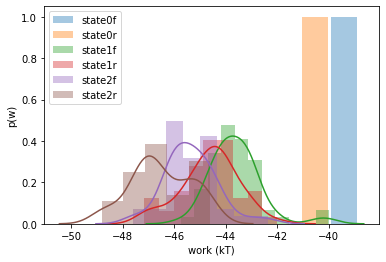

In [16]:
if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:
    
    # Get forward and reverse accumulated works
    forward_complex_combined = np.concatenate(forward_complex_arrays)
    forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
    
    reverse_complex_combined = np.concatenate(reverse_complex_arrays)
    reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        
    forward_apo_combined = np.concatenate(forward_apo_arrays)
    forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])

    reverse_apo_combined = np.concatenate(reverse_apo_arrays)
    reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])

    # Prep input for estimator
    d_input_works = {}
    d_input_works['apo'] = {}
    d_input_works['complex'] = {}
    d_input_works['apo'][0], d_input_works['apo'][1], d_input_works['apo'][2] = list(), list(), list()
    d_input_works['complex'][0], d_input_works['complex'][1], d_input_works['complex'][2] = list(), list(), list()
    n_cycles_apo = len(forward_apo_arrays)
    for i in range(n_cycles_apo):
        state = states_apo[i]
        d_input_works['apo'][state].append([forward_apo_accumulated[i], reverse_apo_accumulated[i]])
        
    n_cycles_complex = len(forward_complex_arrays)
    for i in range(n_cycles_complex):
        state = states_complex[i]
        d_input_works['complex'][state].append([forward_complex_accumulated[i], reverse_complex_accumulated[i]])

    # Analyze 
    print(analyze_minh(np.array(d_input_works['apo'][0]))*KT_KCALMOL)
    print(analyze_minh(np.array(d_input_works['apo'][1]))*KT_KCALMOL)
    print(analyze_minh(np.array(d_input_works['apo'][2]))*KT_KCALMOL)
    
    print(analyze_minh(np.array(d_input_works['complex'][0]))*KT_KCALMOL)
    print(analyze_minh(np.array(d_input_works['complex'][1]))*KT_KCALMOL)
    print(analyze_minh(np.array(d_input_works['complex'][2]))*KT_KCALMOL)
        
        
    # Plot work distributions
#     colors = [['blue', 'cyan'], ['red', 'orange'], ['green', 'forestgreen'] ]
    for i in range(3):
        sns.distplot(np.array(d_input_works['apo'][i])[:,0], label=f"state{i}f")
        sns.distplot(np.array(d_input_works['apo'][i])[:,1]*-1, label=f"state{i}r")
#     plt.axvline(dg)
#     plt.axvline(dg + ddg, linestyle='dashed')
#     plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.legend()
    plt.show()
#     plt.title(f"{title} {phase}")
#     plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
#     print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
#     plt.clf()    
else:
    print(f"dir {i} has at least one phase without data" )

100%|██████████| 10000/10000 [00:01<00:00, 6268.70it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fl

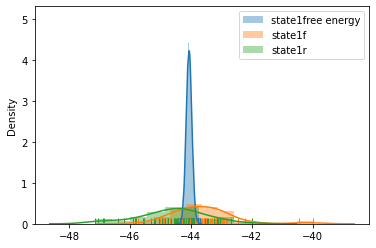

In [17]:
import tqdm
all_free_energies = []
for state in [1]:
    N_bootstraps = 10000
    free_energies = []
    work_array = np.array(d_input_works['apo'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        free_energies.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"state{state}free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:01<00:00, 6534.28it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fl

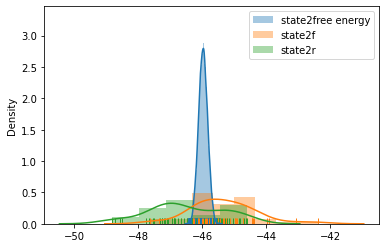

In [18]:
import tqdm
# all_free_energies = []
for state in [2]:
    N_bootstraps = 10000
    free_energies = []
    work_array = np.array(d_input_works['apo'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        free_energies.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"state{state}free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

now, all_free_energies has two sub lists, one for the bootstrapped free energies of state 1, another for state 2

In [19]:
def combine(state_1, state_2):
    return -np.log(np.exp(-state_1) + np.exp(-state_2))

In [20]:
combined_free_energies = []
for i in tqdm.trange(N_bootstraps):
    combined_free_energies.append(combine(all_free_energies[0][i], all_free_energies[1][i]))

100%|██████████| 10000/10000 [00:00<00:00, 101522.34it/s]


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

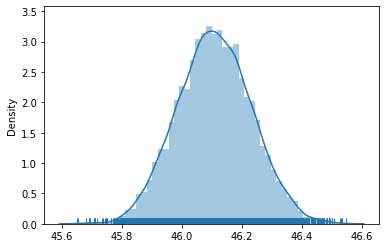

In [21]:
sns.distplot(combined_free_energies, rug=True)

In [22]:
np.mean(combined_free_energies)*KT_KCALMOL

27.4883794106709

In [23]:
np.std(combined_free_energies)*KT_KCALMOL

0.07352991550816976

In [24]:
np.percentile(combined_free_energies, 2.5)*KT_KCALMOL, np.percentile(combined_free_energies, 97.5)*KT_KCALMOL

(27.34537742326802, 27.633666559792328)

100%|██████████| 10000/10000 [00:01<00:00, 7032.02it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fl

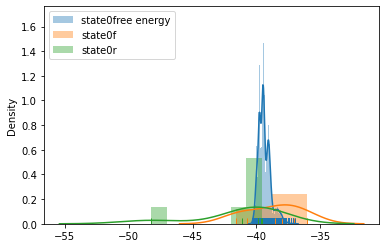

In [25]:
import tqdm
all_free_energies = []
for state in [0]:
    N_bootstraps = 10000
    free_energies = []
    work_array = np.array(d_input_works['complex'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        free_energies.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"state{state}free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:01<00:00, 6877.21it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fl

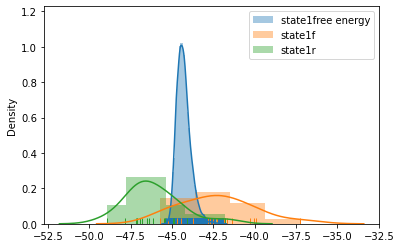

In [26]:
import tqdm
for state in [1]:
    N_bootstraps = 10000
    free_energies = []
    work_array = np.array(d_input_works['complex'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        free_energies.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"state{state}free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:01<00:00, 6200.83it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fl

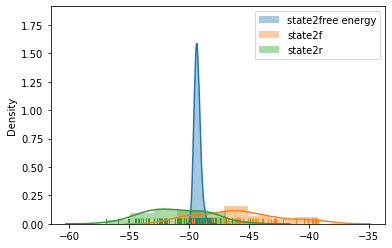

In [27]:
import tqdm
# all_free_energies = []
for state in [2]:
    N_bootstraps = 10000
    free_energies = []
    work_array = np.array(d_input_works['complex'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        free_energies.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"state{state}free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

now, all_free_energies has three sub lists

In [28]:
def combine(state_0, state_1, state_2):
    return -np.log(np.exp(-state_0) + np.exp(-state_1) + np.exp(-state_2))

In [29]:
combined_free_energies = []
for i in tqdm.trange(N_bootstraps):
    combined_free_energies.append(combine(all_free_energies[0][i], all_free_energies[1][i], all_free_energies[2][i]))

100%|██████████| 10000/10000 [00:00<00:00, 71493.78it/s]


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

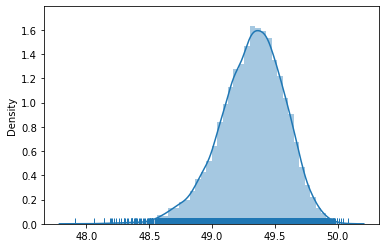

In [30]:
sns.distplot(combined_free_energies, rug=True)

In [31]:
np.mean(combined_free_energies)*KT_KCALMOL

29.400586824066103

In [32]:
np.std(combined_free_energies)*KT_KCALMOL

0.15412290761999645

In [33]:
np.percentile(combined_free_energies, 2.5)*KT_KCALMOL, np.percentile(combined_free_energies, 97.5)*KT_KCALMOL

(29.060826040548505, 29.669673991073715)

In [144]:
29.40 - 27.488

1.911999999999999

Convert to kcal/mol

In [6]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [7]:
d_results_kcalmol = {}
for k, v in d_results.items():
    d_results_kcalmol[k] = [v[0]*KT_KCALMOL, v[1]*KT_KCALMOL]

In [8]:
d_results_kcalmol

{'T42A': [2.595751481355776, 0.15934564264902729],
 'A42T': [-2.4325870383741344, 0.1297532573284111]}

In [18]:
# Get discrepancy and uncertainty
mutations = ["T42A"]
d_analysis = {}
for mutation in mutations:
    reverse = "A42T"
    forward_dg = d_results_kcalmol[mutation][0]
    forward_ddg = d_results_kcalmol[mutation][1]
    reverse_dg = d_results_kcalmol[reverse][0]
    reverse_ddg =  d_results_kcalmol[reverse][1]
    discrepancy = (forward_dg + reverse_dg)
    uncertainty = np.sqrt((forward_ddg)**2 + (reverse_ddg)**2)
    
    d_analysis[mutation] = [forward_dg, forward_ddg, reverse_dg, reverse_ddg, discrepancy, uncertainty, discrepancy/uncertainty]
    
    

In [17]:
d_analysis

{'A42T': [-2.4325870383741344,
  0.1297532573284111,
  2.595751481355776,
  0.15934564264902729,
  0.16316444298164168,
  0.20549195025247186,
  0.7940186600067511]}

In [19]:
import pandas as pd
pd.DataFrame.from_dict(d_analysis, orient='index').to_csv("/data/chodera/zhangi/perses_benchmark/neq/12/analysis.csv")

In [12]:
import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/12/d_results.pickle", "wb") as f:
    pickle.dump(d_results, f)

import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/12/d_phases.pickle", "wb") as f:
    pickle.dump(d_phases, f)


In [4]:
# import pickle
# with open("/data/chodera/zhangi/perses_benchmark/neq/8/d_results.pickle", "rb") as f:
#     d_results = pickle.load(f)

# import pickle
# with open("/data/chodera/zhangi/perses_benchmark/neq/8/d_phases.pickle", "rb") as f:
#     d_phases = pickle.load(f)

In [ ]:
# # Format to match Dominic's table
# d_combined = {}
# rows = [('ALA', 'SER'), ('ALA', 'CYS'), ('ALA', 'THR'), ('SER', 'CYS'), ('SER', 'THR'), ('CYS', 'THR')]
# for pair, (dg, ddg) in sorted(d_results.items()):
#     if pair in rows:
#         d_combined[pair] = [dg, ddg]

# for pair, (dg, ddg) in sorted(d_results.items()):
#     if pair not in d_combined:
#         reversed_pair = pair[::-1]
#         forward_solvation_dg = d_combined[reversed_pair][0]
#         forward_solvation_ddg = d_combined[reversed_pair][1]
#         d_combined[reversed_pair] += [dg, ddg, abs(forward_solvation_dg) - abs(dg), abs(forward_solvation_ddg) - abs(ddg)]



In [ ]:
# # Create dataframe
# df = pd.DataFrame.from_dict(d_combined, orient='index', columns=['forward solvation dG', 
#                                                             'forward solvation ddG', 
#                                                             'reverse solvation dG',
#                                                             'reverse solvation ddG',
#                                                             'discrepancy dG',
#                                                             'discrepancy ddG'
#                                                            ]
                      
#                       )

In [ ]:
# df.reindex(index=rows)

# Compute phase discrepancies

In [13]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [20]:
mutations = ["T42A"]
d_discrepancy = {}
for mutation in mutations:
    reverse = "A42T"
#     d_discrepancy[mutation] = [d_phases[mutation][0]*KT_KCALMOL, d_phases[reverse][0]*KT_KCALMOL, (d_phases[mutation][0] + d_phases[reverse][0])*KT_KCALMOL,
#                                d_phases[mutation][2]*KT_KCALMOL, d_phases[reverse][2]*KT_KCALMOL, (d_phases[mutation][2] + d_phases[reverse][2])*KT_KCALMOL]
    forward_apo_dg = d_phases[mutation][0]*KT_KCALMOL
    forward_apo_ddg = d_phases[mutation][1]*KT_KCALMOL
    reverse_apo_dg = d_phases[reverse][0]*KT_KCALMOL
    reverse_apo_ddg =  d_phases[reverse][1]*KT_KCALMOL
    apo_discrepancy = (d_phases[mutation][0] + d_phases[reverse][0])*KT_KCALMOL
    apo_uncertainty = np.sqrt((d_phases[mutation][1]*KT_KCALMOL)**2 + (d_phases[reverse][1]*KT_KCALMOL)**2)
    
    forward_complex_dg = d_phases[mutation][2]*KT_KCALMOL
    forward_complex_ddg = d_phases[mutation][3]*KT_KCALMOL
    reverse_complex_dg = d_phases[reverse][2]*KT_KCALMOL
    reverse_complex_ddg =  d_phases[reverse][3]*KT_KCALMOL
    complex_discrepancy = (d_phases[mutation][2] + d_phases[reverse][2])*KT_KCALMOL
    complex_uncertainty = np.sqrt((d_phases[mutation][3]*KT_KCALMOL)**2 + (d_phases[reverse][3]*KT_KCALMOL)**2)
    
    d_discrepancy[mutation] = [forward_apo_dg, forward_apo_ddg, reverse_apo_dg, reverse_apo_ddg, apo_discrepancy, apo_uncertainty, apo_discrepancy/apo_uncertainty,
                              forward_complex_dg, forward_complex_ddg, reverse_complex_dg, reverse_complex_ddg, complex_discrepancy, complex_uncertainty, complex_discrepancy/complex_uncertainty]
    
    

In [15]:
d_discrepancy

{'A42T': [-26.772275005198082,
  0.0405669899124021,
  27.190301892583328,
  0.0603178183505878,
  0.4180268873852468,
  0.07269057628831567,
  5.750771402983645,
  -29.204862043572216,
  0.1232486394114756,
  29.786053373939104,
  0.14748828638457023,
  0.5811913303668882,
  0.19220567561192603,
  3.023799003419368]}

In [21]:
import pandas as pd
pd.DataFrame.from_dict(d_discrepancy, orient='index').to_csv("/data/chodera/zhangi/perses_benchmark/neq/12/discrepancies.csv")